## Prepare train and test

In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
#coding:utf8

import sys
sys.path.insert(1, '../src')
from src import PROJECT_PATHS

In [46]:
import pandas as pd
from models import TopicsAnalyzer

In [47]:
df = pd.read_csv(f"{PROJECT_PATHS.data}\\processed\\final_embeded.csv", index_col=0)
df.head()

,LIKES,COMMENTS,target,sin_hour,cos_hour,cos_month,sin_month,cos_weekday,sin_weekday,emb_text_0,...,emb_title_290,emb_title_291,emb_title_292,emb_title_293,emb_title_294,emb_title_295,emb_title_296,emb_title_297,emb_title_298,emb_title_299
0,0.0,50,7,-5.000000e-01,8.660254e-01,0.5,0.866025,-0.222521,-0.974928,0.016769,...,-0.006696,0.007845,-0.022188,-0.030541,0.033095,0.005611,0.079799,-0.060192,0.025157,-0.014475
1,-39.0,152,7,-1.000000e+00,-1.836970e-16,0.5,0.866025,-0.222521,-0.974928,0.027725,...,0.009607,0.032843,-0.062798,-0.040111,-0.056778,-0.000490,-0.004771,0.044609,0.044650,0.067494
2,186.0,30,7,1.224647e-16,-1.000000e+00,0.5,0.866025,-0.222521,-0.974928,0.027246,...,-0.017774,0.024428,-0.010970,-0.017435,-0.016049,-0.002617,0.025836,0.001839,-0.010091,-0.012859
3,48.0,33,7,1.224647e-16,-1.000000e+00,0.5,0.866025,-0.222521,-0.974928,0.037644,...,0.003854,0.045091,0.015493,-0.021446,0.014062,-0.003290,0.072985,-0.022510,0.031925,0.009049
4,27.0,57,7,1.224647e-16,-1.000000e+00,0.5,0.866025,-0.222521,-0.974928,0.033379,...,-0.028516,0.010097,-0.012332,-0.029570,0.022079,-0.014889,0.041341,-0.025642,-0.012887,-0.030432


In [15]:
analyzer = TopicsAnalyzer(df)
len(analyzer.X_test)

23895

## Classification

### SVC

In [23]:
analyzer.SVC()
analyzer.last_score()

0.6847876124712283

### LogisticRegression

In [16]:
analyzer.LogisticRegression()
analyzer.last_score()

0.6862105042896003

### LDA

In [20]:
analyzer.LDA()
analyzer.last_score()

0.6759991630048128

### Подбор гиперпараметров

Воспользуемся методом поиска по сетке для логистической регрессии - алгоритма, показавшего наилучший результат. У данной модели не так много гиперпараметров, и вряд ли тут можно будет увидеть какое-либо улучшение. Будет перебирать регуляризацию (l2 или без) и силу регуляризации. Результаты представим в наглядном виде.

<AxesSubplot:xlabel='penalty', ylabel='C'>

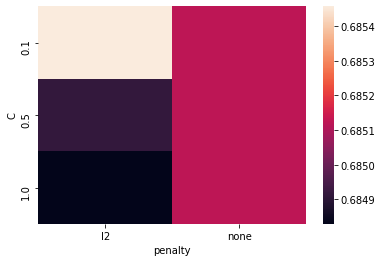

In [26]:
import seaborn as sns

grid_search_results = analyzer.LogisticRegressionGridSearch()

table = pd.pivot_table(grid_search_results,
                       values='score', index='C', columns='penalty')
     
sns.heatmap(table)

Как и ожидалось при l2 регуляризации с силой 1.0 модель получает наилучшие результаты классификации. Абсолютно логично что без регуляризации значение силы регуляризации ни на что не влияет.

### Проверка гипотезы об аномалиях

В процессе EDA было выявлено, что некоторую часть постов можно назвать аномальными. Попробуем проверить мешают ли такие слишком длинные и со слишком большим рейтингом посты решению задачи классификации. Повторим обнаружение аномалий:

In [36]:
from sklearn.ensemble import IsolationForest
import numpy as np

def word_len(df, cols, tokenizer=None):
    statistics_df = pd.DataFrame()
    for col in cols:
        statistics_df[f'len_words_{col}'] = df[col].map(lambda x: len(str(x).split()))
    return statistics_df

df_1 = pd.read_csv(f"{PROJECT_PATHS.data}\\processed\\preprocessed.csv", index_col=0)

In [37]:
df_1.drop(columns=['CURRENT_TIMESTAMP'], inplace=True)
df_1.TITLE = df_1.TITLE.str.lower()
df_1["TIMESTAMP"] = pd.to_datetime(df_1['TIMESTAMP'])
df_1.drop(df_1[df_1['TITLE'] == 'удалено'].index, inplace=True)
df_1["TITLE"][df_1['TITLE'].isnull()] = ''

df_1["HOUR"] = df_1["TIMESTAMP"].map(lambda x: x.hour)
df_1["YEAR"] = df_1["TIMESTAMP"].map(lambda x: x.year)
df_1["MONTH"] = df_1["TIMESTAMP"].map(lambda x: x.month)
df_1["WEEKDAY"] = df_1["TIMESTAMP"].map(lambda x: x.weekday())
df_1["WEEK"] = df_1["TIMESTAMP"].map(lambda x: x.week)

word_len_df = word_len(df_1, ['TEXT', 'TITLE'])
word_len_df['LIKES'] = df_1['LIKES']
word_len_df['LIKES'] = word_len_df['LIKES'].fillna(0)
word_len_df['COMMENTS'] = df_1['COMMENTS']

<ipython-input-37-22f43159ea5e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1["TITLE"][df_1['TITLE'].isnull()] = ''
<ipython-input-37-22f43159ea5e>:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_1["WEEK"] = df_1["TIMESTAMP"].map(lambda x: x.week)


In [38]:
clf = IsolationForest( max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(word_len_df)

unique, counts = np.unique(preds, return_counts=True)
dict(zip(unique, counts))

{-1: 16123, 1: 79457}

In [48]:
df_new = df[preds == 1]
df_new.shape

(79457, 609)

Теперь попробуем применить классификацию на данных, не содержащих аномалий:

In [49]:
new_analyzer = TopicsAnalyzer(df_new)
new_analyzer.LogisticRegression()
new_analyzer.last_score()

0.6906619682859301

Как можно видеть, качество классификации после удаления обнаруженных аномалий повысилось. В связи с этим, можно сделать вывод, что некоторые посты с аномальными параметрами немного зашумляли входные данные и мешали работе моделей классификации.

## TopicModeling

### LDA

Remove the stop words from the texts, apply lemmatization. After that, let's look at the top 10 words in each topic modeled by the LDA algorithm.

In [36]:
analyzer.MakeTfIdf()
analyzer.TopicModeling()

vocab = analyzer.vectorizer.get_feature_names()

n_top_words = 10

topic_words = {}

for topic, comp in enumerate(analyzer.topics):    
    word_idx = np.argsort(comp)[::-1][:n_top_words]
    print([vocab[x] for x in word_idx],"\n")

['украина', 'россия', 'страна', 'это', 'который', 'украинский', 'российский', 'год', 'президент', 'власть'] 

['рори', 'лерой', 'небензя', 'негритенок', 'хьялдур', 'мики', 'дженкинс', 'деж', 'щербань', 'мигель'] 

['работа', 'работать', 'это', 'деньги', 'компания', 'зарплата', 'месяц', 'мочь', 'год', 'получать'] 

['михална', 'дудик', 'галустян', 'перчиков', 'стиляга', 'byn', 'академа', 'эпштейн', 'монастырский', 'затулин'] 

['yafud', 'що', 'україни', 'шикотан', 'симеон', 'свереда', 'форли', 'фифа', 'тутси', 'від'] 

['хейдар', 'глебович', 'гавриил', 'одиссей', 'ида', 'настасья', 'у0', 'kota', 'камилла', 'stranitsa'] 

['ницой', 'кл', 'агидель', 'клинцы', 'пердануть', 'ζωήσκατά', 'светозар', 'пж', 'наталка', 'ельченко'] 

['это', 'весь', 'ребенок', 'свой', 'человек', 'год', 'мочь', 'который', 'друг', 'говорить'] 

['агамемнон', 'одиссей', 'паламед', 'аякса', 'ахиллес', 'менелай', 'артес', 'гомер', 'аннель', 'хамус'] 

['нафтогаз', 'газпром', 'газ', 'басурин', 'кубометр', 'пашинян', 'г

Алгоритму удалось выделить какие-то 10 тем из набора документов. Если посмотреть на самые популярные слова в каждой категории можно определить некоторые из изначальных тем, например, политику, работу, украину. Однако можно видеть, что алгоритм выделил некоторые по-другому, например имена различных персонажей древнегреческой мифологии наверняка часто встречались в поэзии и истории, но в данном случае получилось, что это отдельная тема. Таким образом алгоритм ЛДА неплохо выделил различные темы, хоть они и отличаются местами от изначальных. 

## Clustering

### Kmeans-fasttext

In [45]:
analyzer.Clustering()
analyzer.clustering_score

c:\users\stanislav\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +


-0.2815778626037387

### Kmeans-tfifd

In [48]:
analyzer.Clustering(True)
analyzer.clustering_score

c:\users\stanislav\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +


4.945087741830758

Результаты кластеризации, к сожалению, оставляют желать лучшего. Полученное качество алгоритм не 